## Prepare grades for comments

In [1]:
import pandas as pd

In [2]:
path = '../other_dumps/comments'

In [3]:
# open the file where we'll add the final decision about comments
df_with_comments = pd.read_csv(f'{path}/VER5_all_comments_to_theories_with_scores.csv')
df_with_comments.head()

,id,status,thread,text,time,content_link,block_name,enabled,abuses,likes,replies,anon_user_id,area,step_id,topic_id,lemmatized_comments,count_writing,count_unclearness
0,9403,fixed,comment,"""...to divide between two your friends""\r\nI t...",2019-06-08 20:14:45,https://hyperskill.org/learn/step/5614,text,0,0,0,0,45,math,5614,370.0,""" ... to divide between two your friend "" \r\n...",0,0
1,9408,won't fix,comment,"It was not completely clear for me, how to con...",2019-06-08 20:32:26,https://hyperskill.org/learn/step/5614,text,1,0,3,2,45,math,5614,370.0,"it be not completely clear for I , how to conv...",1,1
2,15054,fixed,feedback,completly not understood,2019-07-09 11:11:43,https://hyperskill.org/learn/step/5753,text,1,0,0,0,105,math,5753,385.0,completly not understand,1,0
3,15115,fixed,feedback,A better explanation is needed with clear defi...,2019-07-09 17:34:21,https://hyperskill.org/learn/step/5753,text,1,0,0,0,109,math,5753,385.0,a well explanation be need with clear definiti...,2,0
4,15268,fixed,comment,>remember that 2^8 in decimal is 1000 0000 in ...,2019-07-10 16:03:41,https://hyperskill.org/learn/step/5753,text,0,0,1,0,122,math,5753,385.0,> remember that 2 ^ 8 in decimal be 1000 0000 ...,0,0


<AxesSubplot:>

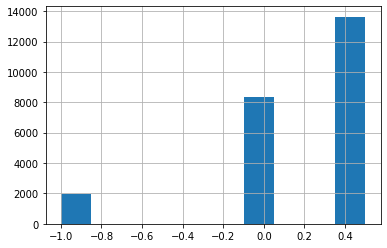

In [5]:
# here grades are not based on polarities

grades = []

for i, row in df_with_comments.iterrows():
    if (row.count_writing == 0) and (row.count_unclearness == 0):  
        # if there are no suspicious words in the comment, we mark it separately
        grades.append(0.5)
        continue
    
    elif (row.count_writing > 0) and (row.count_unclearness > 0): 
        # if words from both thematic fields are present, it's a bad comment
        grades.append(-1)
        continue
    
    else:  # if a word from only one of the lists is present, it's a neutral comment
        grades.append(0)
    
df_with_comments['comment_grades'] = grades
df_with_comments.comment_grades.hist()

In [6]:
print(df_with_comments[df_with_comments.comment_grades == -1].shape[0])  # 'bad' comments
print(df_with_comments[df_with_comments.comment_grades == 0.5].shape[0])  # comments without trigger words
print(df_with_comments[df_with_comments.comment_grades == 0].shape[0])  # all other comments

1958
13632
8315


In [7]:
df_with_comments.to_csv(f'{path}/VER5_all_comments_to_theories_with_scores.csv', index=False)

## Split topics according to comments' grades

In [8]:
def count_good_and_bad_comments_per_each_topic(df):
    """
    We need to store IDs of comments, to be able to check the number of their reactions later.
    """
    bad_comments_count_for_topics = dict()
    good_comments_count_for_topics = dict()

    for i, row in df.iterrows():
        status = row['status']
        comment_grade = row['comment_grades']
        topic_id = row['topic_id']

        # add the bad comments count
        if topic_id in bad_comments_count_for_topics:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id].append(row.id)
            else:
                pass  # topic is in the dict but this comment is not bad so we don't add it

        else:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id] = [row.id]  # this is the first comment for topic and it's bad
            else:
                bad_comments_count_for_topics[topic_id] = []  # this is the first comment for topic and it's not bad

        # now add the good comments count
        if topic_id in good_comments_count_for_topics:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id].append(row.id)
            else:
                pass 
        else:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id] = [row.id]  
            else:
                good_comments_count_for_topics[topic_id] = []
                
    return bad_comments_count_for_topics, good_comments_count_for_topics

In [9]:
bad_comments_count_for_topics, good_comments_count_for_topics = count_good_and_bad_comments_per_each_topic(df_with_comments)

In [10]:
bad_comments_count_for_topics[362]

[193128, 223285, 331036, 1100637, 1279082, 1297032, 1579354]

In [11]:
def divide_into_bad_and_rest(bad_comments_count_for_topics, threshold):
    """
    For each topic, if it has >=threshold bad comments -- it's bad. Otherwise it's 'the rest'.
    """
    final_bad_topics = []
    final_rest_topics = []

    for topic_id in bad_comments_count_for_topics:
        bad_num = len(bad_comments_count_for_topics[topic_id])

        if bad_num >= threshold:
            final_bad_topics.append(topic_id)
        else:
            final_rest_topics.append(topic_id)
            
    return final_bad_topics, final_rest_topics

In [12]:
final_bad_topics_2, final_rest_topics_2 = divide_into_bad_and_rest(bad_comments_count_for_topics, threshold=2)

In [13]:
print('good dataset', len(final_rest_topics_2))
print('bad dataset', len(final_bad_topics_2))

good dataset 792
bad dataset 328


In [14]:
final_bad_topics_3, final_rest_topics_3 = divide_into_bad_and_rest(bad_comments_count_for_topics, threshold=3)

In [15]:
print('good dataset', len(final_rest_topics_3))
print('bad dataset', len(final_bad_topics_3))

good dataset 897
bad dataset 223


## Check the division of the topics with high likes and extend the corpus

In [16]:
import pickle

In [17]:
step_id_topic_id_mapping = pickle.load(open('step_id_topic_id_mapping.pkl', 'br'))

In [18]:
file = '../topics_with_statistics/topics_3_months_with_statistics_and_scores.csv'
topic_statistics = pd.read_csv(file)

In [19]:
# df with topcis where we can trust likes (with >20 evaluations)
more_likes = topic_statistics[topic_statistics.last_3_month_likes_count > 20]
very_good_topics = more_likes[more_likes.last_3_month_avg_like > 1.85]
good_like_steps = [row['step_id'] for i, row in very_good_topics.iterrows()]
good_like_topics = set([step_id_topic_id_mapping[step_id] for step_id in good_like_steps])

In [20]:
intersected_good_like_bad_comments_2 = good_like_topics.intersection(final_bad_topics_2)
print(len(intersected_good_like_bad_comments_2)) 

33


In [21]:
intersected_good_like_bad_comments_3 = good_like_topics.intersection(final_bad_topics_3)
print(len(intersected_good_like_bad_comments_3)) 

16


In [22]:
for el in intersected_good_like_bad_comments_3:
    print(el)

673.0
5.0
6.0
518.0
585.0
234.0
77.0
429.0
431.0
240.0
529.0
530.0
624.0
434.0
597.0
475.0


From what we've already checked:

- 673 -- bad
- 5
- 6 -- bad
- 518
- 585 -- bad
- 234
- 77
- 429 -- bad
- 431
- 240
- 529 -- bad
- 530 -- bad
- 624
- 434
- 597
- 475

In [24]:
# let's check the rest
bad_topics = [5, 518, 234, 77, 431, 240, 624, 434, 597, 475]

for el in bad_topics:
    print('#####' * 8 + str(el) + '####' * 8)
    comments_for_this_topic = df_with_comments[df_with_comments.topic_id == el]
    for com in comments_for_this_topic.text.values:
        if len(com) < 10000:
            print(com)
            print('<-------------->')
    print()

########################################5################################
So I'm not sure this was covered but:
Overloading is adding more or different parameters to a method.
<-------------->
Incorrectly
public void invokeInstanceMethod(String s) {
        System.out.println("SubClass: overloaded invokeInstanceMethod");
    }
/* clazz.invokeInstanceMethod("s"); // SubClass: overloaded invokeInstanceMethod(String) */
<-------------->
Excellent explanation
Thanks, Hyperskill!
<-------------->
Try this:

public class Main {
    public static void main(String[] args) {
        SuperClass objectAsSuper = new ChildClass();
        ChildClass objectAsChild = new ChildClass();

        objectAsSuper.dontOverride();
        objectAsSuper.pleaseOverride();
        
        objectAsChild.dontOverride();
        objectAsChild.pleaseOverride();
        
        objectAsChild.completelyNewMewthod();
        // no completelyNewMethod() for objectAsSuper

    }
}

class SuperClass {
    protected voi

- 5 -- bad (a lot of commments asking for a better explanation)
- 518 -- same
- 234 -- same
- 77 -- same
- 431 -- write about poor English!
- 240 -- write about needing more examples 
- 624 -- write that it's not explained well!
- 434 -- not exactly bad but people don't understand some cases
- 597 -- mention some part that is badly written
- 475 -- both good and bad feedbacks

In [25]:
df_with_features = pd.DataFrame({'topic_id': list([int(el) for el in final_bad_topics_3]) +\
                                 list([int(el) for el in final_rest_topics_3]), 
                                'target': [1] * len(final_bad_topics_3) + [0] * len(final_rest_topics_3)})

In [26]:
path = './new_cleaned/train_corpus/target_features'
df_with_features.to_csv(f'{path}/topic_ids_with_target_features_VER5.csv', index=False)

## Split topics taking likes into account

In [31]:
path = '/home/anna/Documents/Diploma/other_dumps/comments'
df_with_comments = pd.read_csv(f'{path}/VER5_all_comments_to_theories_with_scores.csv')

In [32]:
df_with_comments.head()

,id,status,thread,text,time,content_link,block_name,enabled,abuses,likes,replies,anon_user_id,area,step_id,topic_id,lemmatized_comments,count_writing,count_unclearness,comment_grades
0,9403,fixed,comment,"""...to divide between two your friends""\r\nI t...",2019-06-08 20:14:45,https://hyperskill.org/learn/step/5614,text,0,0,0,0,45,math,5614,370.0,""" ... to divide between two your friend "" \r\n...",0,0,0.5
1,9408,won't fix,comment,"It was not completely clear for me, how to con...",2019-06-08 20:32:26,https://hyperskill.org/learn/step/5614,text,1,0,3,2,45,math,5614,370.0,"it be not completely clear for I , how to conv...",1,1,-1.0
2,15054,fixed,feedback,completly not understood,2019-07-09 11:11:43,https://hyperskill.org/learn/step/5753,text,1,0,0,0,105,math,5753,385.0,completly not understand,1,0,0.0
3,15115,fixed,feedback,A better explanation is needed with clear defi...,2019-07-09 17:34:21,https://hyperskill.org/learn/step/5753,text,1,0,0,0,109,math,5753,385.0,a well explanation be need with clear definiti...,2,0,0.0
4,15268,fixed,comment,>remember that 2^8 in decimal is 1000 0000 in ...,2019-07-10 16:03:41,https://hyperskill.org/learn/step/5753,text,0,0,1,0,122,math,5753,385.0,> remember that 2 ^ 8 in decimal be 1000 0000 ...,0,0,0.5


In [40]:
def count_good_and_bad_comments_with_likes(df):
    """
    We add the comment as many times as many likes it has.
    """
    bad_comments_count_for_topics = dict()
    good_comments_count_for_topics = dict()

    for i, row in df.iterrows():
        status = row['status']
        comment_grade = row['comment_grades']
        topic_id = row['topic_id']
        likes = row['likes']

        # add the bad comments count
        if topic_id in bad_comments_count_for_topics:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id].append(row.id)
                
                # now add as many same IDs as there are likes
                bad_comments_count_for_topics[topic_id].extend([row.id] * likes)
                
            else:
                pass  # topic is in the dict but this comment is not bad so we don't add it

        else:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id] = [row.id]  # this is the first comment for topic and it's bad
                bad_comments_count_for_topics[topic_id].extend([row.id] * likes)
            else:
                bad_comments_count_for_topics[topic_id] = []  # this is the first comment for topic and it's not bad

        # now add the good comments count
        if topic_id in good_comments_count_for_topics:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id].append(row.id)
                good_comments_count_for_topics[topic_id].extend([row.id] * likes)
            else:
                pass 
        else:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id] = [row.id]
                good_comments_count_for_topics[topic_id].extend([row.id] * likes)
            else:
                good_comments_count_for_topics[topic_id] = []
                
    return bad_comments_count_for_topics, good_comments_count_for_topics

In [41]:
bad_comments_count_for_topics, good_comments_count_for_topics = count_good_and_bad_comments_with_likes(df_with_comments)

In [42]:
def divide_into_bad_and_rest(bad_comments_count_for_topics, threshold):
    """
    For each topic, if it has >=threshold bad comments -- it's bad. Otherwise it's 'the rest'.
    """
    final_bad_topics = []
    final_rest_topics = []

    for topic_id in bad_comments_count_for_topics:
        bad_num = len(bad_comments_count_for_topics[topic_id])

        if bad_num >= threshold:
            final_bad_topics.append(topic_id)
        else:
            final_rest_topics.append(topic_id)
            
    return final_bad_topics, final_rest_topics

In [43]:
final_bad_topics_3, final_rest_topics_3 = divide_into_bad_and_rest(bad_comments_count_for_topics, threshold=3)

In [44]:
print('good dataset', len(final_rest_topics_3))
print('bad dataset', len(final_bad_topics_3))

# previously it was
#good dataset 897
#bad dataset 223

good dataset 803
bad dataset 317


In [45]:
intersected_good_like_bad_comments_3 = good_like_topics.intersection(final_bad_topics_3)
print(len(intersected_good_like_bad_comments_3)) 

27


In [ ]:
# now there's more intersection with the good likes comments
# but as we've checked, good like doesn't always mean the absense of confused comments

In [46]:
df_with_features = pd.DataFrame({'topic_id': list([int(el) for el in final_bad_topics_3]) +\
                                 list([int(el) for el in final_rest_topics_3]), 
                                'target': [1] * len(final_bad_topics_3) + [0] * len(final_rest_topics_3)})

In [47]:
path = './new_cleaned/train_corpus/target_features'
df_with_features.to_csv(f'{path}/topic_ids_with_target_features_VER5_with_likes.csv', index=False)